# Pre-processing and analysis of feature barcode single-cell RNA-seq data with KITE.

In this notebook, we will perform pre-processing and analysis of [10x Genomics pbmc_1k_protein_v3](https://support.10xgenomics.com/single-cell-gene-expression/datasets/3.0.0/pbmc_1k_protein_v3) feature barcoding dataset using the **Kallisto Indexing and Tag Extraction (KITE)** workflow, implemented with a wrapper called `kb`. It was developed by Kyung Hoi (Joseph) Min and A. Sina Booeshaghi.

In Feature Barcoding assays, cellular data are recorded as short DNA sequences using procedures adapted from single-cell RNA-seq. The **KITE** workflow generates a "Mismatch Map" containing the sequences of all Feature Barcodes used in the experiment as well as all of their single-base mismatches. The Mismatch Map is used to produce transcipt-to-gene (.t2g) and fasta (.fa) files to be used as inputs for kallisto. An index is made with kallisto index, then kallisto | bustools effectively searches the sequencing data for the sequences in the Mismatch Map.

## Pre-processing

### Download the data

__Note:__ We use the `-O` option for `wget` to rename the files to easily identify them.

In [0]:
%%time
!wget https://caltech.box.com/shared/static/asmj4nu90ydhsrk3pm7aaxu00cnnfige.txt -O checksums.txt
!wget https://caltech.box.com/shared/static/mp2vr3p6dztdyatuag8ir3cektmrztg8.gz -O pbmc_1k_protein_v3_antibody_S2_L001_R1_001.fastq.gz
!wget https://caltech.box.com/shared/static/f3payi1za7mn0jfai7vm10sy3yqwgpqh.gz -O pbmc_1k_protein_v3_antibody_S2_L001_R2_001.fastq.gz
!wget https://caltech.box.com/shared/static/e112bbczh9o1rl6gfin36bqp0ga7uvdy.gz -O pbmc_1k_protein_v3_antibody_S2_L002_R1_001.fastq.gz
!wget https://caltech.box.com/shared/static/3ve2axc8dr8v5nnrhmynrdgpqj6xg42k.gz -O pbmc_1k_protein_v3_antibody_S2_L002_R2_001.fastq.gz

--2020-01-15 23:30:46--  https://caltech.box.com/shared/static/asmj4nu90ydhsrk3pm7aaxu00cnnfige.txt
Resolving caltech.box.com (caltech.box.com)... 107.152.27.197, 107.152.26.197
Connecting to caltech.box.com (caltech.box.com)|107.152.27.197|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /public/static/asmj4nu90ydhsrk3pm7aaxu00cnnfige.txt [following]
--2020-01-15 23:30:47--  https://caltech.box.com/public/static/asmj4nu90ydhsrk3pm7aaxu00cnnfige.txt
Reusing existing connection to caltech.box.com:443.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://caltech.app.box.com/public/static/asmj4nu90ydhsrk3pm7aaxu00cnnfige.txt [following]
--2020-01-15 23:30:47--  https://caltech.app.box.com/public/static/asmj4nu90ydhsrk3pm7aaxu00cnnfige.txt
Resolving caltech.app.box.com (caltech.app.box.com)... 107.152.25.199, 107.152.24.199
Connecting to caltech.app.box.com (caltech.app.box.com)|107.152.25.199|:443... connected.
HTTP requ

Then, we verify the integrity of the files we downloaded to make sure they were not corrupted during the download.

In [0]:
!md5sum -c checksums.txt --ignore-missing

pbmc_1k_protein_v3_antibody_S2_L001_R1_001.fastq.gz: OK
pbmc_1k_protein_v3_antibody_S2_L001_R2_001.fastq.gz: OK
pbmc_1k_protein_v3_antibody_S2_L002_R1_001.fastq.gz: OK
pbmc_1k_protein_v3_antibody_S2_L002_R2_001.fastq.gz: OK


### Install `kb`

Install `kb` for running the kallisto|bustools workflow.

In [0]:
!pip install git+https://github.com/pachterlab/kb_python@count-kite

  Cloning https://github.com/pachterlab/kb_python (to revision count-kite) to /tmp/pip-req-build-ijboqjx7
  Running command git clone -q https://github.com/pachterlab/kb_python /tmp/pip-req-build-ijboqjx7
  Running command git checkout -b count-kite --track origin/count-kite
  Switched to a new branch 'count-kite'
  Branch 'count-kite' set up to track remote branch 'count-kite' from 'origin'.
     |████████████████████████████████| 51kB 2.5MB/s 
     |████████████████████████████████| 51kB 7.5MB/s 
     |████████████████████████████████| 61kB 8.0MB/s 
     |████████████████████████████████| 51kB 6.7MB/s 
  Created wheel for kb-python: filename=kb_python-0.24.4-cp36-none-any.whl size=80381943 sha256=a321915d8605576908ac7e00a38e02a921d30f572ac59ed8208a7a69513ec758
  Stored in directory: /tmp/pip-ephem-wheel-cache-se6n68ix/wheels/8e/56/56/c89223de74af26792675e82f4bb5223e7cf0d653a33038e34c
  Created wheel for loompy: filename=loompy-3.0.6-cp36-none-any.whl size=47896 sha256=f0f0f873d0617d2

### Build the feature barcode mismatch index

`kb` is able to generate a FASTA file containing all hamming distance < 2 variants of the feature barcodes and create a kallisto index of these sequences. But it in order to do so, we first need to prepare a TSV containing feature barcode sequences in the first column and the feature barcode names in the second.

First, we download the feature reference file provided by 10x Genomics.

In [0]:
!wget http://cf.10xgenomics.com/samples/cell-exp/3.0.0/pbmc_1k_protein_v3/pbmc_1k_protein_v3_feature_ref.csv

--2020-01-15 23:32:15--  http://cf.10xgenomics.com/samples/cell-exp/3.0.0/pbmc_1k_protein_v3/pbmc_1k_protein_v3_feature_ref.csv
Resolving cf.10xgenomics.com (cf.10xgenomics.com)... 13.224.29.124, 13.224.29.102, 13.224.29.56, ...
Connecting to cf.10xgenomics.com (cf.10xgenomics.com)|13.224.29.124|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1473 (1.4K) [text/csv]
Saving to: ‘pbmc_1k_protein_v3_feature_ref.csv’

pbmc_1k_protein_v3_ 100%[===================>]   1.44K  --.-KB/s    in 0s      

2020-01-15 23:32:15 (165 MB/s) - ‘pbmc_1k_protein_v3_feature_ref.csv’ saved [1473/1473]



Let's load it in as a Pandas DataFrame.

In [0]:
import pandas as pd

df = pd.read_csv('pbmc_1k_protein_v3_feature_ref.csv')
df

,id,name,read,pattern,sequence,feature_type
0,CD3,CD3_TotalSeqB,R2,5PNNNNNNNNNN(BC)NNNNNNNNN,AACAAGACCCTTGAG,Antibody Capture
1,CD4,CD4_TotalSeqB,R2,5PNNNNNNNNNN(BC)NNNNNNNNN,TACCCGTAATAGCGT,Antibody Capture
2,CD8a,CD8a_TotalSeqB,R2,5PNNNNNNNNNN(BC)NNNNNNNNN,ATTGGCACTCAGATG,Antibody Capture
3,CD14,CD14_TotalSeqB,R2,5PNNNNNNNNNN(BC)NNNNNNNNN,GAAAGTCAAAGCACT,Antibody Capture
4,CD15,CD15_TotalSeqB,R2,5PNNNNNNNNNN(BC)NNNNNNNNN,ACGAATCAATCTGTG,Antibody Capture
5,CD16,CD16_TotalSeqB,R2,5PNNNNNNNNNN(BC)NNNNNNNNN,GTCTTTGTCAGTGCA,Antibody Capture
6,CD56,CD56_TotalSeqB,R2,5PNNNNNNNNNN(BC)NNNNNNNNN,GTTGTCCGACAATAC,Antibody Capture
7,CD19,CD19_TotalSeqB,R2,5PNNNNNNNNNN(BC)NNNNNNNNN,TCAACGCTTGGCTAG,Antibody Capture
8,CD25,CD25_TotalSeqB,R2,5PNNNNNNNNNN(BC)NNNNNNNNN,GTGCATTCAACAGTA,Antibody Capture
9,CD45RA,CD45RA_TotalSeqB,R2,5PNNNNNNNNNN(BC)NNNNNNNNN,GATGAGAACAGGTTT,Antibody Capture


We'll convert this dataframe into a TSV format that `kb` requires.

In [0]:
df[['sequence', 'id']].to_csv('features.tsv', index=None, header=None, sep='\t')
!cat features.tsv

AACAAGACCCTTGAG	CD3
TACCCGTAATAGCGT	CD4
ATTGGCACTCAGATG	CD8a
GAAAGTCAAAGCACT	CD14
ACGAATCAATCTGTG	CD15
GTCTTTGTCAGTGCA	CD16
GTTGTCCGACAATAC	CD56
TCAACGCTTGGCTAG	CD19
GTGCATTCAACAGTA	CD25
GATGAGAACAGGTTT	CD45RA
TGCATGTCATCGGTG	CD45RO
AAGTCGTGAGGCATG	PD-1
TGAAGGCTCATTTGT	TIGIT
ACATTGACGCAACTA	CD127
CTCTATTCAGACCAG	IgG2a
ACTCACTGGAGTCTC	IgG1
ATCACATCGTTGCCA	IgG2b


Finally, we use `kb` to generate the mismatch kallisto index.

In [0]:
!kb ref -i mismatch.idx -f1 mismatch.fa -g t2g.txt --workflow kite features.tsv

[2020-01-15 23:32:21,669]    INFO Generating mismatch FASTA at mismatch.fa
[2020-01-15 23:32:21,680]    INFO Creating transcript-to-gene mapping at t2g.txt
[2020-01-15 23:32:21,684]    INFO Indexing to mismatch.idx


### Generate a feature count matrix in H5AD format

The following command will generate an RNA count matrix of cells (rows) by genes (columns) in H5AD format, which is a binary format used to store [Anndata](https://anndata.readthedocs.io/en/stable/) objects. Notice we are providing the index and transcript-to-gene mapping we generated in the previous step to the `-i` and `-g` arguments respectively. Also, these reads were generated with the 10x Genomics Chromium Single Cell v3 Chemistry, hence the `-x 10xv3` argument. To view other supported technologies, run `kb --list`.

__Note:__ If you would like a Loom file instead, replace the `--h5ad` flag with `--loom`. If you want to use the raw matrix output by `kb` instead of their H5AD or Loom converted files, omit these flags.

In [0]:
%%time
!kb count --h5ad -i mismatch.idx -g t2g.txt -x 10xv3 --workflow kite -t 2 \
pbmc_1k_protein_v3_antibody_S2_L001_R1_001.fastq.gz \
pbmc_1k_protein_v3_antibody_S2_L001_R2_001.fastq.gz \
pbmc_1k_protein_v3_antibody_S2_L002_R1_001.fastq.gz \
pbmc_1k_protein_v3_antibody_S2_L002_R2_001.fastq.gz

[2020-01-15 23:32:28,148]    INFO Generating BUS file from
[2020-01-15 23:32:28,148]    INFO         pbmc_1k_protein_v3_antibody_S2_L001_R1_001.fastq.gz
[2020-01-15 23:32:28,148]    INFO         pbmc_1k_protein_v3_antibody_S2_L001_R2_001.fastq.gz
[2020-01-15 23:32:28,148]    INFO         pbmc_1k_protein_v3_antibody_S2_L002_R1_001.fastq.gz
[2020-01-15 23:32:28,148]    INFO         pbmc_1k_protein_v3_antibody_S2_L002_R2_001.fastq.gz
[2020-01-15 23:34:23,527]    INFO Sorting BUS file ./output.bus to ./tmp/output.s.bus
[2020-01-15 23:34:34,619]    INFO Whitelist not provided
[2020-01-15 23:34:34,619]    INFO Copying pre-packaged 10XV3 whitelist to .
[2020-01-15 23:34:35,535]    INFO Inspecting BUS file ./tmp/output.s.bus
[2020-01-15 23:34:42,910]    INFO Correcting BUS records in ./tmp/output.s.bus to ./tmp/output.s.c.bus with whitelist ./10xv3_whitelist.txt
[2020-01-15 23:34:59,040]    INFO Sorting BUS file ./tmp/output.s.c.bus to ./output.unfiltered.bus
[2020-01-15 23:35:07,894]    INFO 

## Analysis

In this part of the tutorial, we will load the RNA count matrix generated by `kb count` into Python and cluster the cells with Leiden.

### Install packages

Google Colab does not come with `Scanpy`, `python-igraph`, or `louvain` (but comes with `matplotlib`, `numpy`, `pandas`, and `scipy`).

In [0]:
!pip install leidenalg scanpy MulticoreTSNE

     |████████████████████████████████| 102kB 4.7MB/s 
     |████████████████████████████████| 317kB 15.5MB/s 
     |████████████████████████████████| 378kB 41.3MB/s 
     |████████████████████████████████| 13.0MB 54.1MB/s 
     |████████████████████████████████| 51kB 7.0MB/s 
  Created wheel for leidenalg: filename=leidenalg-0.7.0-cp36-cp36m-linux_x86_64.whl size=1104867 sha256=9fa39f77fd8a43de76be0788ec28b1273681be13da29dfe558c876eead3be36f
  Stored in directory: /root/.cache/pip/wheels/29/55/48/5a04693a10f50297bcda23819ca23ab3470a61dd911851c8bd
  Created wheel for MulticoreTSNE: filename=MulticoreTSNE-0.1-cp36-cp36m-linux_x86_64.whl size=68507 sha256=05e5da74abe7e90b95993cc4d7cf19f320cc84225dd53b5efc94cbc733004b5c
  Stored in directory: /root/.cache/pip/wheels/27/59/53/3b52ee63add3692254c30d687fa4dff4d128d0557861fb028e
  Created wheel for python-igraph: filename=python_igraph-0.7.1.post6-cp36-cp36m-linux_x86_64.whl size=2224304 sha256=cc023e1a4a81a0938a8bf55f988c4b4bacf24932611019f2

### Import packages

In [0]:
import anndata
import numpy as np
import scanpy as sc

In [0]:
adata = anndata.read_h5ad('counts_unfiltered/adata.h5ad')

In [0]:
adata

AnnData object with n_obs × n_vars = 124716 × 17 

In [0]:
adata.obs.head()

""
index
AAACCCAAGAAACCCA
AAACCCAAGACGAGGA
AAACCCAAGAGTGTGT
AAACCCAAGAGTGTTG
AAACCCAAGATAGCAC


In [0]:
adata.var

""
index
CD3
CD4
CD8a
CD14
CD15
CD16
CD56
CD19
CD25


### Plot counts

In [0]:
sc.pp.filter_cells(adata, min_counts=0)

In [0]:
sc.pp.filter_genes(adata, min_counts=0)

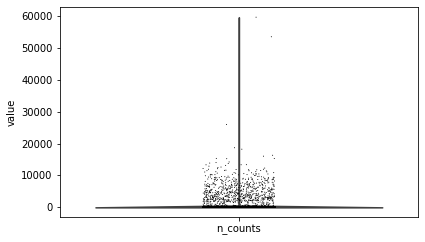

In [0]:
sc.pl.violin(adata, keys='n_counts')

In [0]:
adata.obs['n_countslog'] = np.log1p(adata.obs['n_counts'])

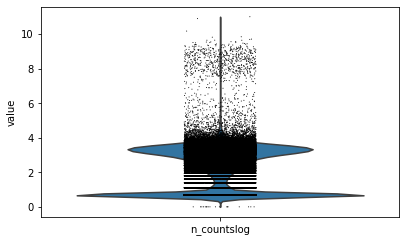

In [0]:
sc.pl.violin(adata, keys='n_countslog')

In [0]:
adata.obs.index

Index(['AAACCCAAGAAACCCA', 'AAACCCAAGACGAGGA', 'AAACCCAAGAGTGTGT',
       'AAACCCAAGAGTGTTG', 'AAACCCAAGATAGCAC', 'AAACCCAAGATGAGTC',
       'AAACCCAAGATGGTAC', 'AAACCCAAGATTCGTT', 'AAACCCAAGATTTGGG',
       'AAACCCAAGCAAGCAT',
       ...
       'TTTGTTGTCGTCGCCT', 'TTTGTTGTCGTTGACG', 'TTTGTTGTCTAACCGG',
       'TTTGTTGTCTATGTAG', 'TTTGTTGTCTCAACAA', 'TTTGTTGTCTCACTCA',
       'TTTGTTGTCTCTTCGA', 'TTTGTTGTCTCTTGGT', 'TTTGTTGTCTGCACTT',
       'TTTGTTGTCTGCGACA'],
      dtype='object', name='index', length=124716)

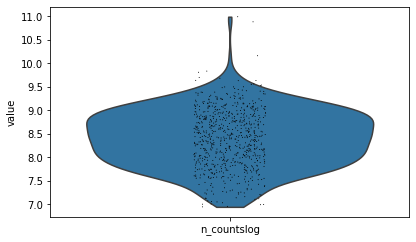

AnnData object with n_obs × n_vars = 725 × 17 
    obs: 'n_counts', 'n_countslog'
    var: 'n_counts'

In [0]:
sc.pp.filter_cells(adata, min_counts=1000)
sc.pl.violin(adata, keys='n_countslog', title="kallisto UMI counts")
adata

Here are violin plots for each Feature Barcode (antibody-oligo conjugates, x-axis) across all cells.

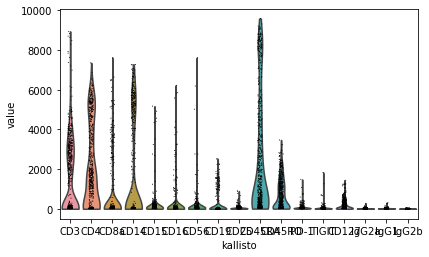

In [0]:
sc.pl.violin(adata, keys=list(adata.var.index)[-17:], xlabel='kallisto')

### Cluster with Leiden

In [0]:
sc.pp.normalize_per_cell(adata, counts_per_cell_after=10000)

In [0]:
sc.pp.neighbors(adata)
sc.tl.umap(adata)

In [0]:
sc.tl.leiden(adata, resolution=0.05)

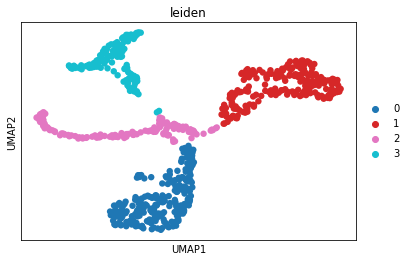

In [0]:
sc.pl.umap(adata, color='leiden', palette='tab10')

### Embedding and Antibody Quantification

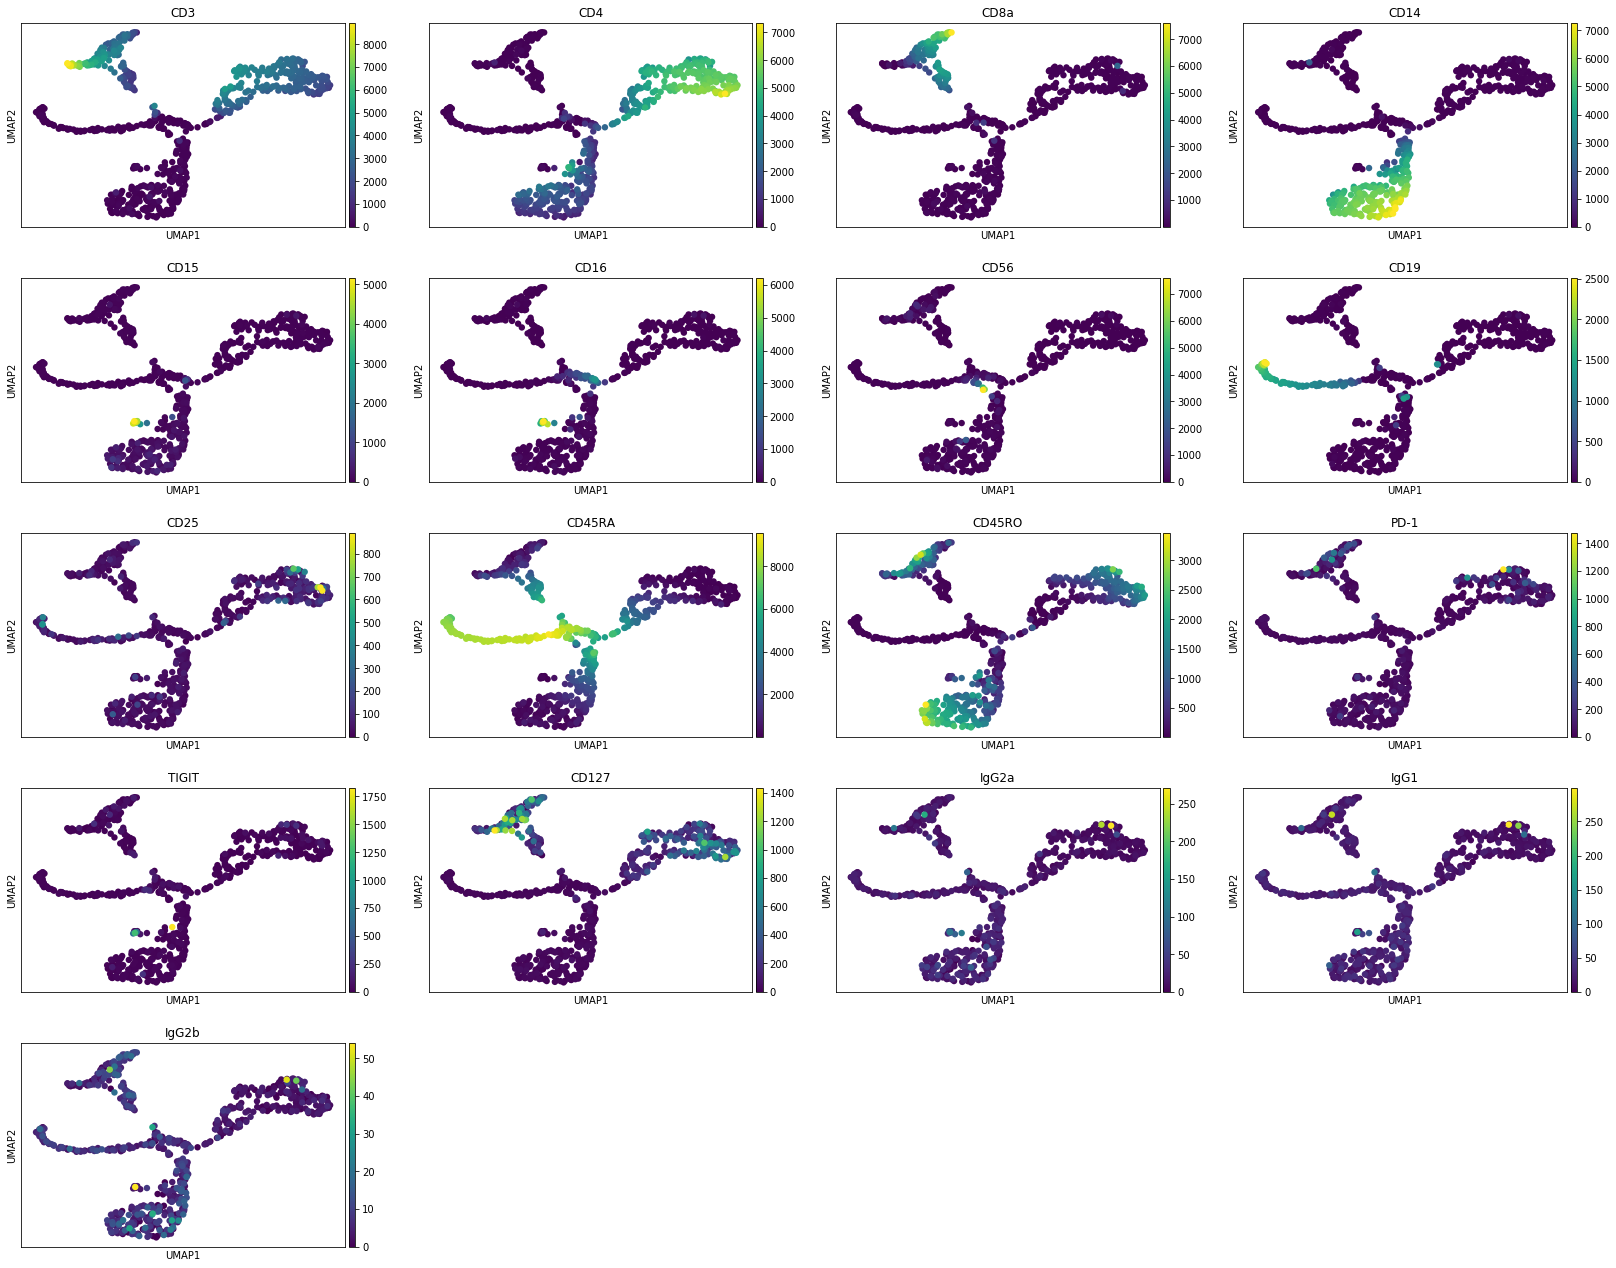

In [0]:
sc.pl.umap(adata, color=adata.var.index)

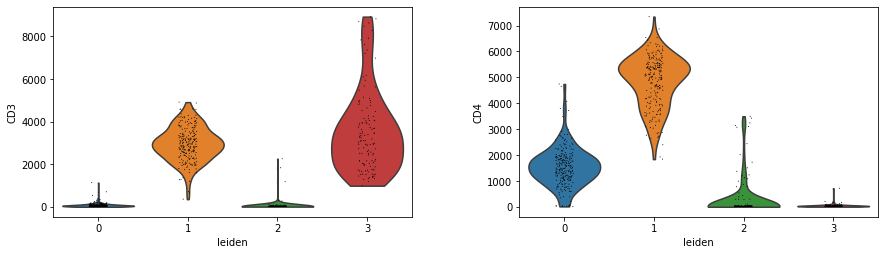

In [0]:
sc.pl.violin(adata, keys=list(adata.var.index[:2]), groupby='leiden')